In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
cd '/content/drive/MyDrive/job a thon'

/content/drive/MyDrive/job a thon


# Libraries

In [ ]:
!pip install featuretools

In [ ]:
!pip install git+https://github.com/scikit-optimize/scikit-optimize.git

In [ ]:
!pip install catboost

In [15]:
# importing required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,recall_score,accuracy_score, roc_auc_score, precision_recall_curve, plot_roc_curve
from matplotlib import pyplot
from sklearn.model_selection import GridSearchCV
import featuretools as ft
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

sns.set_style("whitegrid")

import warnings 
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
%config InlineBackend.figure_format='retina'

# Data Understanding

In [16]:
# train
customer_df = pd.read_csv("train.csv")
print(customer_df.shape)
customer_df.head()

(50882, 14)


,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [17]:
# test

test_df = pd.read_csv("test.csv")
print(test_df.shape)
test_df.head()

(21805, 13)


,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
0,50883,C1,156,Owned,Individual,30,30,No,NaN,6.0,3.0,5,11934.0
1,50884,C4,7,Owned,Joint,69,68,Yes,X1,3.0,3.0,18,32204.8
2,50885,C1,564,Rented,Individual,28,28,No,X3,2.0,4.0,17,9240.0
3,50886,C3,1177,Rented,Individual,23,23,No,X3,3.0,3.0,18,9086.0
4,50887,C1,951,Owned,Individual,75,75,No,X3,NaN,NaN,5,22534.0


In [18]:
# changing data-types
# ID, Region_Code, Holding_Policy_Type,Reco_Policy_Cat

change_type_list = ['ID', 'Region_Code', 'Holding_Policy_Type','Reco_Policy_Cat']

for i in change_type_list:
  #train
  customer_df[i] = customer_df[i].astype('object')

  #test

  test_df[i] = test_df[i].astype('object')


customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  object 
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  object 
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         39191 non-null  object 
 9   Holding_Policy_Duration  30631 non-null  object 
 10  Holding_Policy_Type      30631 non-null  object 
 11  Reco_Policy_Cat          50882 non-null  object 
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
dtypes: float64(1), int64(3

# Missing values

In [19]:
round(customer_df.isnull().mean()*100,2)

ID                          0.00
City_Code                   0.00
Region_Code                 0.00
Accomodation_Type           0.00
Reco_Insurance_Type         0.00
Upper_Age                   0.00
Lower_Age                   0.00
Is_Spouse                   0.00
Health Indicator           22.98
Holding_Policy_Duration    39.80
Holding_Policy_Type        39.80
Reco_Policy_Cat             0.00
Reco_Policy_Premium         0.00
Response                    0.00
dtype: float64

- there are some missing values present.
- if we look carefully Holding_Policy_Duration and Holding_Policy_Type have excat same number of missing vlaues. 39.80%.
- Health Indicator have 23% of missing values.
- need to investigate to choose what to impute for missing values.


In [20]:
# test
round(test_df.isnull().mean()*100,2)

ID                          0.00
City_Code                   0.00
Region_Code                 0.00
Accomodation_Type           0.00
Reco_Insurance_Type         0.00
Upper_Age                   0.00
Lower_Age                   0.00
Is_Spouse                   0.00
Health Indicator           23.05
Holding_Policy_Duration    39.45
Holding_Policy_Type        39.45
Reco_Policy_Cat             0.00
Reco_Policy_Premium         0.00
dtype: float64

In [21]:
# lets check for  Holding_Policy_Duration and Holding_Policy_Type

round((customer_df[customer_df["Holding_Policy_Duration"].isnull() & customer_df["Holding_Policy_Type"].isnull()].shape[0] / customer_df.shape[0]) * 100,3)

39.8

- here we can see that, when there is missing values at Holding_Policy_Duration, Holding_Policy_Type also have missing values. 

- and their percentage values missing matches the Above findings. so there must be a pattern behind the missing values here.

- From data dictionary we can see that, Holding_Policy_Duration and Holding_Policy_Type indicates to already exsisting customer.
- what if a there is someone new who didnt hold any policy. we can conclude that these null values indicate the someone new.
- for Holding_Policy_Duration we can put 0 years and for Holding_Policy_Type we can put -1 to indicate that person does not hold any.


In [22]:
# filling Null values

customer_df.Holding_Policy_Duration = customer_df.Holding_Policy_Duration.fillna('0')
customer_df.Holding_Policy_Type = customer_df.Holding_Policy_Type.fillna('-1')

#test

test_df.Holding_Policy_Duration = test_df.Holding_Policy_Duration.fillna('0')
test_df.Holding_Policy_Type = test_df.Holding_Policy_Type.fillna('-1')


customer_df.isnull().sum()

ID                             0
City_Code                      0
Region_Code                    0
Accomodation_Type              0
Reco_Insurance_Type            0
Upper_Age                      0
Lower_Age                      0
Is_Spouse                      0
Health Indicator           11691
Holding_Policy_Duration        0
Holding_Policy_Type            0
Reco_Policy_Cat                0
Reco_Policy_Premium            0
Response                       0
dtype: int64

In [23]:
test_df.isnull().sum()

ID                            0
City_Code                     0
Region_Code                   0
Accomodation_Type             0
Reco_Insurance_Type           0
Upper_Age                     0
Lower_Age                     0
Is_Spouse                     0
Health Indicator           5027
Holding_Policy_Duration       0
Holding_Policy_Type           0
Reco_Policy_Cat               0
Reco_Policy_Premium           0
dtype: int64

In [24]:
# now lets check for Health Indicator
customer_df["Health Indicator"].unique()

array(['X1', 'X2', nan, 'X4', 'X3', 'X6', 'X5', 'X8', 'X7', 'X9'],
      dtype=object)

In [25]:
# lets create a unknown category since we dont know about health status of these customers
customer_df["Health Indicator"] = customer_df["Health Indicator"].fillna('Unknown')

# test
test_df["Health Indicator"] = test_df["Health Indicator"].fillna('Unknown')

customer_df.isnull().sum()

ID                         0
City_Code                  0
Region_Code                0
Accomodation_Type          0
Reco_Insurance_Type        0
Upper_Age                  0
Lower_Age                  0
Is_Spouse                  0
Health Indicator           0
Holding_Policy_Duration    0
Holding_Policy_Type        0
Reco_Policy_Cat            0
Reco_Policy_Premium        0
Response                   0
dtype: int64

now there is no missing values present

In [26]:
test_df.isnull().sum()

ID                         0
City_Code                  0
Region_Code                0
Accomodation_Type          0
Reco_Insurance_Type        0
Upper_Age                  0
Lower_Age                  0
Is_Spouse                  0
Health Indicator           0
Holding_Policy_Duration    0
Holding_Policy_Type        0
Reco_Policy_Cat            0
Reco_Policy_Premium        0
dtype: int64

In [27]:
#customer_df.set_index('ID',inplace=True)
#customer_df.head()

# Feature Engineering

In [28]:
# new or old customer
customer_df["Customer_status"] = customer_df["Holding_Policy_Type"].apply(lambda x: 0 if x=='-1' else 1)
#test
test_df["Customer_status"] = test_df["Holding_Policy_Type"].apply(lambda x: 0 if x=='-1' else 1)



# Average Age
customer_df["Avg_Age"] = round((customer_df.Upper_Age + customer_df.Lower_Age) / 2)
#test
test_df["Avg_Age"] = round((test_df.Upper_Age + test_df.Lower_Age) / 2)



# age difference
customer_df["Age_diff"] = customer_df.Upper_Age - customer_df.Lower_Age
#test
test_df["Age_diff"] = test_df.Upper_Age - test_df.Lower_Age


# log transform
customer_df["Reco_Policy_Premium"] = np.log(customer_df["Reco_Policy_Premium"])
#test
test_df["Reco_Policy_Premium"] = np.log(test_df["Reco_Policy_Premium"])

### Feature Tools

In [29]:
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  object 
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  object 
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         50882 non-null  object 
 9   Holding_Policy_Duration  50882 non-null  object 
 10  Holding_Policy_Type      50882 non-null  object 
 11  Reco_Policy_Cat          50882 non-null  object 
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
 14  Customer_status       

In [30]:
for i in customer_df.columns:
  if customer_df[i].dtype == 'object':
    customer_df[i] = customer_df[i].astype(str)

# test
for i in test_df.columns:
  if test_df[i].dtype == 'object':
    test_df[i] = test_df[i].astype(str)

In [31]:
feature_eng = customer_df.copy()
#test
feature_eng_test = test_df.copy()

feature_eng.drop("Response",axis=1, inplace=True)

feature_eng["common_id"] = feature_eng["City_Code"].astype(str) + feature_eng.Region_Code.astype(str)

#test
feature_eng_test["common_id"] = feature_eng_test["City_Code"].astype(str) + feature_eng_test.Region_Code.astype(str)

In [32]:
import featuretools.variable_types as vtypes
variable_types = {'Upper_Age': vtypes.Ordinal,
                  'Lower_Age': vtypes.Ordinal,
                  'Avg_Age': vtypes.Ordinal,
                  }

In [33]:
es = ft.EntitySet('Health')
es = es.entity_from_dataframe(entity_id="health",
                              dataframe=feature_eng,
                              index='ID',
                              variable_types=variable_types)
es['health']

Entity: health
  Variables:
    ID (dtype: index)
    City_Code (dtype: categorical)
    Region_Code (dtype: categorical)
    Accomodation_Type (dtype: categorical)
    Reco_Insurance_Type (dtype: categorical)
    Is_Spouse (dtype: categorical)
    Health Indicator (dtype: categorical)
    Holding_Policy_Duration (dtype: categorical)
    Holding_Policy_Type (dtype: categorical)
    Reco_Policy_Cat (dtype: categorical)
    Reco_Policy_Premium (dtype: numeric)
    Customer_status (dtype: numeric)
    Age_diff (dtype: numeric)
    common_id (dtype: categorical)
    Upper_Age (dtype: ordinal)
    Lower_Age (dtype: ordinal)
    Avg_Age (dtype: ordinal)
  Shape:
    (Rows: 50882, Columns: 17)

In [34]:
#test
es_test = ft.EntitySet('Health')
es_test = es_test.entity_from_dataframe(entity_id="health",
                              dataframe=feature_eng_test,
                              index='ID',
                              variable_types=variable_types)
es_test['health']

Entity: health
  Variables:
    ID (dtype: index)
    City_Code (dtype: categorical)
    Region_Code (dtype: categorical)
    Accomodation_Type (dtype: categorical)
    Reco_Insurance_Type (dtype: categorical)
    Is_Spouse (dtype: categorical)
    Health Indicator (dtype: categorical)
    Holding_Policy_Duration (dtype: categorical)
    Holding_Policy_Type (dtype: categorical)
    Reco_Policy_Cat (dtype: categorical)
    Reco_Policy_Premium (dtype: numeric)
    Customer_status (dtype: numeric)
    Age_diff (dtype: numeric)
    common_id (dtype: categorical)
    Upper_Age (dtype: ordinal)
    Lower_Age (dtype: ordinal)
    Avg_Age (dtype: ordinal)
  Shape:
    (Rows: 21805, Columns: 17)

In [35]:
# Make a patients entity with patient-specific variables
es.normalize_entity('health', 'insurence', 'common_id',
                    additional_variables=['Health Indicator',
                                          'Holding_Policy_Duration',
                                          'Holding_Policy_Type',
                                          
                                          'Customer_status',
                                          'Reco_Policy_Premium'])

Entityset: Health
  Entities:
    health [Rows: 50882, Columns: 12]
    insurence [Rows: 5297, Columns: 6]
  Relationships:
    health.common_id -> insurence.common_id

In [36]:
# test
es_test.normalize_entity('health', 'insurence', 'common_id',
                    additional_variables=['Health Indicator',
                                          'Holding_Policy_Duration',
                                          'Holding_Policy_Type',
                                          
                                          'Customer_status',
                                          'Reco_Policy_Premium'])

Entityset: Health
  Entities:
    health [Rows: 21805, Columns: 12]
    insurence [Rows: 4675, Columns: 6]
  Relationships:
    health.common_id -> insurence.common_id

In [37]:
# Show the patients entity
es['insurence'].df.head(2)


,common_id,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Customer_status,Reco_Policy_Premium
C33213,C33213,X1,14+,3.0,1,9.361171
C51117,C51117,X2,0,-1,0,10.325810


In [38]:
#test
es_test['insurence'].df.head(2)

,common_id,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Customer_status,Reco_Policy_Premium
C1156,C1156,Unknown,6.0,3.0,1,9.387147
C47,C47,X1,3.0,3.0,1,10.379871


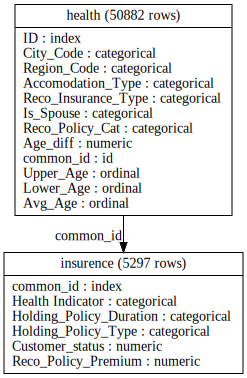

In [39]:
es.plot()

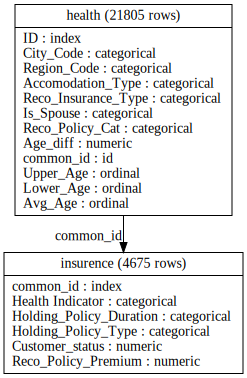

In [40]:
es_test.plot()

In [41]:
fm, features = ft.dfs(entityset=es, target_entity='health',max_depth=5,
                      approximate='6h',verbose=True)

Built 41 features
Elapsed: 00:17 | Progress: 100%|██████████


In [42]:
#test
fm_test, features_test = ft.dfs(entityset=es_test, target_entity='health',max_depth=5,
                      approximate='6h',verbose=True)

Built 41 features
Elapsed: 00:14 | Progress: 100%|██████████


In [43]:
fm_test.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Is_Spouse,Reco_Policy_Cat,Age_diff,common_id,Upper_Age,Lower_Age,Avg_Age,insurence.Health Indicator,insurence.Holding_Policy_Duration,insurence.Holding_Policy_Type,insurence.Customer_status,insurence.Reco_Policy_Premium,insurence.COUNT(health),insurence.MAX(health.Age_diff),insurence.MEAN(health.Age_diff),insurence.MIN(health.Age_diff),insurence.MODE(health.Accomodation_Type),insurence.MODE(health.Avg_Age),insurence.MODE(health.City_Code),insurence.MODE(health.Is_Spouse),insurence.MODE(health.Lower_Age),insurence.MODE(health.Reco_Insurance_Type),insurence.MODE(health.Reco_Policy_Cat),insurence.MODE(health.Region_Code),insurence.MODE(health.Upper_Age),insurence.NUM_UNIQUE(health.Accomodation_Type),insurence.NUM_UNIQUE(health.Avg_Age),insurence.NUM_UNIQUE(health.City_Code),insurence.NUM_UNIQUE(health.Is_Spouse),insurence.NUM_UNIQUE(health.Lower_Age),insurence.NUM_UNIQUE(health.Reco_Insurance_Type),insurence.NUM_UNIQUE(health.Reco_Policy_Cat),insurence.NUM_UNIQUE(health.Region_Code),insurence.NUM_UNIQUE(health.Upper_Age),insurence.SKEW(health.Age_diff),insurence.STD(health.Age_diff),insurence.SUM(health.Age_diff)
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50883,C1,156,Owned,Individual,No,5,0,C1156,30,30,30.0,Unknown,6.0,3.0,1,9.387147,18,39,3.111111,0,Owned,62.0,C1,No,61,Individual,5,156,63,1,16.0,1,2,15,2,8,1,14,3.647067,9.467523,56
50884,C4,7,Owned,Joint,Yes,18,1,C47,69,68,68.0,X1,3.0,3.0,1,10.379871,35,29,2.371429,0,Rented,20.0,C4,No,20,Individual,18,7,20,2,23.0,1,2,23,2,5,1,26,3.116337,6.490199,83
50885,C1,564,Rented,Individual,No,17,0,C1564,28,28,28.0,X3,2.0,4.0,1,9.131297,12,5,0.500000,0,Owned,59.0,C1,No,59,Individual,22,564,59,2,11.0,1,2,11,2,5,1,10,3.247344,1.445998,6
50886,C3,1177,Rented,Individual,No,18,0,C31177,23,23,23.0,X3,3.0,3.0,1,9.114490,6,26,4.666667,0,Owned,23.0,C3,No,20,Individual,18,1177,23,2,6.0,1,2,6,2,3,1,6,2.418448,10.481730,28
50887,C1,951,Owned,Individual,No,5,0,C1951,75,75,75.0,X3,0,-1,0,10.022781,12,42,7.250000,0,Owned,23.0,C1,No,18,Individual,5,951,23,2,12.0,1,2,12,2,3,1,12,1.827215,13.968308,87


In [44]:
# removing columns from here, later will concat it with manual features dataframe

remove_cols = ['City_Code', 'Region_Code', 'Accomodation_Type', 'Reco_Insurance_Type',
       'Is_Spouse', 'Reco_Policy_Cat', 'Age_diff', 'common_id', 'Upper_Age',
       'Lower_Age', 'Avg_Age', 'insurence.Health Indicator',
       'insurence.Holding_Policy_Duration', 'insurence.Holding_Policy_Type',
       'insurence.Customer_status', 'insurence.Reco_Policy_Premium']

In [45]:
fm.drop(remove_cols,axis=1,inplace=True)

#test
fm_test.drop(remove_cols,axis=1,inplace=True)

In [46]:
fm.reset_index(drop=True, inplace=True)
fm.head()

,insurence.COUNT(health),insurence.MAX(health.Age_diff),insurence.MEAN(health.Age_diff),insurence.MIN(health.Age_diff),insurence.MODE(health.Accomodation_Type),insurence.MODE(health.Avg_Age),insurence.MODE(health.City_Code),insurence.MODE(health.Is_Spouse),insurence.MODE(health.Lower_Age),insurence.MODE(health.Reco_Insurance_Type),insurence.MODE(health.Reco_Policy_Cat),insurence.MODE(health.Region_Code),insurence.MODE(health.Upper_Age),insurence.NUM_UNIQUE(health.Accomodation_Type),insurence.NUM_UNIQUE(health.Avg_Age),insurence.NUM_UNIQUE(health.City_Code),insurence.NUM_UNIQUE(health.Is_Spouse),insurence.NUM_UNIQUE(health.Lower_Age),insurence.NUM_UNIQUE(health.Reco_Insurance_Type),insurence.NUM_UNIQUE(health.Reco_Policy_Cat),insurence.NUM_UNIQUE(health.Region_Code),insurence.NUM_UNIQUE(health.Upper_Age),insurence.SKEW(health.Age_diff),insurence.STD(health.Age_diff),insurence.SUM(health.Age_diff)
0,8,2,0.250000,0,Rented,25.0,C3,No,25,Individual,21,3213,25,2,8.0,1,2,8,2,5,1,8,2.828427,0.707107,2
1,17,53,6.705882,0,Owned,26.0,C5,No,37,Individual,22,1117,26,2,12.0,1,2,13,2,4,1,14,2.620804,14.848252,114
2,7,2,0.285714,0,Rented,23.0,C5,No,23,Individual,1,3732,30,2,7.0,1,2,7,2,2,1,6,2.645751,0.755929,2
3,5,4,0.800000,0,Owned,53.0,C24,No,53,Individual,2,4378,53,1,4.0,1,1,4,2,4,1,4,2.236068,1.788854,4
4,11,30,7.000000,0,Owned,34.0,C8,No,19,Joint,16,2190,33,2,10.0,1,2,9,2,3,1,7,1.751014,11.610340,77


In [47]:
#test
fm_test.reset_index(drop=True, inplace=True)
fm_test.head()

,insurence.COUNT(health),insurence.MAX(health.Age_diff),insurence.MEAN(health.Age_diff),insurence.MIN(health.Age_diff),insurence.MODE(health.Accomodation_Type),insurence.MODE(health.Avg_Age),insurence.MODE(health.City_Code),insurence.MODE(health.Is_Spouse),insurence.MODE(health.Lower_Age),insurence.MODE(health.Reco_Insurance_Type),insurence.MODE(health.Reco_Policy_Cat),insurence.MODE(health.Region_Code),insurence.MODE(health.Upper_Age),insurence.NUM_UNIQUE(health.Accomodation_Type),insurence.NUM_UNIQUE(health.Avg_Age),insurence.NUM_UNIQUE(health.City_Code),insurence.NUM_UNIQUE(health.Is_Spouse),insurence.NUM_UNIQUE(health.Lower_Age),insurence.NUM_UNIQUE(health.Reco_Insurance_Type),insurence.NUM_UNIQUE(health.Reco_Policy_Cat),insurence.NUM_UNIQUE(health.Region_Code),insurence.NUM_UNIQUE(health.Upper_Age),insurence.SKEW(health.Age_diff),insurence.STD(health.Age_diff),insurence.SUM(health.Age_diff)
0,18,39,3.111111,0,Owned,62.0,C1,No,61,Individual,5,156,63,1,16.0,1,2,15,2,8,1,14,3.647067,9.467523,56
1,35,29,2.371429,0,Rented,20.0,C4,No,20,Individual,18,7,20,2,23.0,1,2,23,2,5,1,26,3.116337,6.490199,83
2,12,5,0.500000,0,Owned,59.0,C1,No,59,Individual,22,564,59,2,11.0,1,2,11,2,5,1,10,3.247344,1.445998,6
3,6,26,4.666667,0,Owned,23.0,C3,No,20,Individual,18,1177,23,2,6.0,1,2,6,2,3,1,6,2.418448,10.481730,28
4,12,42,7.250000,0,Owned,23.0,C1,No,18,Individual,5,951,23,2,12.0,1,2,12,2,3,1,12,1.827215,13.968308,87


## Manual Features

In [48]:
manu_feat = customer_df.copy()

#test
manu_feat_test = test_df.copy()

In [49]:
manu_feat.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,Customer_status,Avg_Age,Age_diff
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,9.361171,0,1,36.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,0,-1,22,10.325810,0,0,48.0,53
2,3,C5,3732,Owned,Individual,32,32,No,Unknown,1.0,1.0,19,8.915969,1,1,32.0,0
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,9.785830,0,1,50.0,4
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,9.249946,0,1,44.0,0


In [50]:
# combine features

def combine_features(col1, col2, df):

  for i in col1:
    for j in col2:

      if i != j:

        df[i +'_'+ j] = df[i].astype('str') +'_'+ df[j].astype('str')
        



      else:
        continue

In [51]:
combine_feature_1 = ["City_Code","Region_Code","Accomodation_Type","Reco_Insurance_Type","Health Indicator",
                     "Holding_Policy_Duration","Holding_Policy_Type","Reco_Policy_Cat"]

combine_feature_2 = ["Health Indicator","Holding_Policy_Duration","Holding_Policy_Type","Reco_Policy_Cat"]

combine_features(col1=combine_feature_1, col2=combine_feature_1, df =manu_feat)

combine_features(col1=combine_feature_1, col2=combine_feature_1, df =manu_feat_test)

In [52]:
# combining 3 features

# combine feature 3
cols_3 = ['City_Code','Region_Code','Accomodation_Type','Health Indicator','Holding_Policy_Duration']

for i in cols_3:
  manu_feat['Reco_Policy_Cat_Holding_Policy_Type'+'_'+i] = manu_feat["Reco_Policy_Cat"].astype('str') + "_" + manu_feat["Holding_Policy_Type"].astype('str')+ "_"+ manu_feat[i].astype('str')


for i in cols_3:
  manu_feat_test['Reco_Policy_Cat_Holding_Policy_Type'+'_'+i] = manu_feat_test["Reco_Policy_Cat"].astype('str') + "_" + manu_feat_test["Holding_Policy_Type"].astype('str')+ "_"+ manu_feat_test[i].astype('str')

In [53]:
additional_3_cols = ['Reco_Policy_Cat_Holding_Policy_Type_City_Code',
       'Reco_Policy_Cat_Holding_Policy_Type_Region_Code',
       'Reco_Policy_Cat_Holding_Policy_Type_Accomodation_Type',
       'Reco_Policy_Cat_Holding_Policy_Type_Health Indicator',
       'Reco_Policy_Cat_Holding_Policy_Type_Holding_Policy_Duration']

In [54]:
customer_df.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,Customer_status,Avg_Age,Age_diff
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,9.361171,0,1,36.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,0,-1,22,10.325810,0,0,48.0,53
2,3,C5,3732,Owned,Individual,32,32,No,Unknown,1.0,1.0,19,8.915969,1,1,32.0,0
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,9.785830,0,1,50.0,4
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,9.249946,0,1,44.0,0


In [55]:
manu_feat.shape

(50882, 78)

In [56]:
# ratios Features, and mean std transformations

manu_feat["premimum_mean"] = manu_feat["Reco_Policy_Premium"] - manu_feat["Reco_Policy_Premium"].mean()
manu_feat["premium_std"] = manu_feat["premimum_mean"] / manu_feat["Reco_Policy_Premium"].std()

manu_feat["Upper_Age_mean"] = manu_feat["Upper_Age"] - manu_feat["Upper_Age"].mean()
manu_feat["Upper_Age_std"] = manu_feat["Upper_Age"] / manu_feat["Upper_Age"].std()


#test
manu_feat_test["premimum_mean"] = manu_feat_test["Reco_Policy_Premium"] - manu_feat_test["Reco_Policy_Premium"].mean()
manu_feat_test["premium_std"] = manu_feat_test["premimum_mean"] / manu_feat_test["Reco_Policy_Premium"].std()

manu_feat_test["Upper_Age_mean"] = manu_feat_test["Upper_Age"] - manu_feat_test["Upper_Age"].mean()
manu_feat_test["Upper_Age_std"] = manu_feat_test["Upper_Age"] / manu_feat_test["Upper_Age"].std()


In [57]:
def to_mean_and_std(col1, col2, df):

  for i in col1:
    for j in col2:

      if i != j:

        df[i + '_to_mean_' + j] = df[i] / df.groupby([j])[i].transform('mean')
        df[i + '_to_std_' + j] = df[i] / df.groupby([j])[i].transform('std')



      else:
        continue



In [58]:
col1 = ["Reco_Policy_Premium","Upper_Age", "Avg_Age","premimum_mean","premium_std","Upper_Age_mean","Upper_Age_std"]



col2 = [
 'City_Code',
 'Region_Code',
 'Accomodation_Type',
 'Reco_Insurance_Type',
 'Is_Spouse',
 'Health Indicator',
 'Holding_Policy_Duration',
 'Holding_Policy_Type',
 'Reco_Policy_Cat',
 
 'City_Code_Health Indicator',
 'City_Code_Holding_Policy_Duration',
 'City_Code_Holding_Policy_Type',
 'City_Code_Reco_Policy_Cat',
 
 'Region_Code_Health Indicator',
 'Region_Code_Holding_Policy_Duration',
 'Region_Code_Holding_Policy_Type',
 'Region_Code_Reco_Policy_Cat',
 
 'Accomodation_Type_Reco_Insurance_Type',
 'Accomodation_Type_Health Indicator',
 'Accomodation_Type_Holding_Policy_Duration',
 'Accomodation_Type_Holding_Policy_Type',
 'Accomodation_Type_Reco_Policy_Cat',
 
 'Reco_Insurance_Type_Health Indicator',
 'Reco_Insurance_Type_Holding_Policy_Duration',
 'Reco_Insurance_Type_Holding_Policy_Type',
 'Reco_Insurance_Type_Reco_Policy_Cat',
 
 'Health Indicator_Holding_Policy_Duration',
 'Health Indicator_Holding_Policy_Type',
 'Health Indicator_Reco_Policy_Cat',

 
 'Holding_Policy_Type_Holding_Policy_Duration',
 'Holding_Policy_Type_Reco_Policy_Cat',

 ]

col2 = col2 + additional_3_cols

In [59]:
# transforming

to_mean_and_std(col1=col1, col2=col2,df=manu_feat)

#test
to_mean_and_std(col1=col1, col2=col2, df=manu_feat_test)

In [60]:
manu_feat.shape, manu_feat_test.shape

((50882, 586), (21805, 585))

In [61]:
# log , squre, cube features.

log_cols = ['Upper_Age','Reco_Policy_Premium','Avg_Age',]

for i in log_cols:
  manu_feat[i+"_log"] = np.log(manu_feat[i])
  manu_feat[i+"_sqr"] = np.square(manu_feat[i])
  manu_feat[i+"_cube"] = manu_feat[i] ** 3

# test
for i in log_cols:
  manu_feat_test[i+"_log"] = np.log(manu_feat_test[i])
  manu_feat_test[i+"_sqr"] = np.square(manu_feat_test[i])
  manu_feat_test[i+"_cube"] = manu_feat_test[i] ** 3

In [62]:
manu_feat.shape , fm.shape, manu_feat_test.shape , fm_test.shape

((50882, 595), (50882, 25), (21805, 594), (21805, 25))

In [63]:
# joining Featuretool features and manual features.

health_feat_engg = pd.concat([manu_feat, fm],axis=1)

#test
health_feat_engg_test = pd.concat([manu_feat_test, fm_test],axis=1)

In [64]:
health_feat_engg.shape, health_feat_engg_test.shape

((50882, 620), (21805, 619))

In [65]:
health_feat_engg.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,Customer_status,Avg_Age,Age_diff,City_Code_Region_Code,City_Code_Accomodation_Type,City_Code_Reco_Insurance_Type,City_Code_Health Indicator,City_Code_Holding_Policy_Duration,City_Code_Holding_Policy_Type,City_Code_Reco_Policy_Cat,Region_Code_City_Code,Region_Code_Accomodation_Type,Region_Code_Reco_Insurance_Type,Region_Code_Health Indicator,Region_Code_Holding_Policy_Duration,Region_Code_Holding_Policy_Type,Region_Code_Reco_Policy_Cat,Accomodation_Type_City_Code,Accomodation_Type_Region_Code,Accomodation_Type_Reco_Insurance_Type,Accomodation_Type_Health Indicator,Accomodation_Type_Holding_Policy_Duration,Accomodation_Type_Holding_Policy_Type,Accomodation_Type_Reco_Policy_Cat,Reco_Insurance_Type_City_Code,Reco_Insurance_Type_Region_Code,Reco_Insurance_Type_Accomodation_Type,Reco_Insurance_Type_Health Indicator,Reco_Insurance_Type_Holding_Policy_Duration,Reco_Insurance_Type_Holding_Policy_Type,Reco_Insurance_Type_Reco_Policy_Cat,Health Indicator_City_Code,Health Indicator_Region_Code,Health Indicator_Accomodation_Type,Health Indicator_Reco_Insurance_Type,Health Indicator_Holding_Policy_Duration,Health Indicator_Holding_Policy_Type,Health Indicator_Reco_Policy_Cat,Holding_Policy_Duration_City_Code,Holding_Policy_Duration_Region_Code,Holding_Policy_Duration_Accomodation_Type,Holding_Policy_Duration_Reco_Insurance_Type,Holding_Policy_Duration_Health Indicator,Holding_Policy_Duration_Holding_Policy_Type,Holding_Policy_Duration_Reco_Policy_Cat,Holding_Policy_Type_City_Code,Holding_Policy_Type_Region_Code,Holding_Policy_Type_Accomodation_Type,Holding_Policy_Type_Reco_Insurance_Type,Holding_Policy_Type_Health Indicator,Holding_Policy_Type_Holding_Policy_Duration,Holding_Policy_Type_Reco_Policy_Cat,Reco_Policy_Cat_City_Code,Reco_Policy_Cat_Region_Code,Reco_Policy_Cat_Accomodation_Type,Reco_Policy_Cat_Reco_Insurance_Type,Reco_Policy_Cat_Health Indicator,Reco_Policy_Cat_Holding_Policy_Duration,Reco_Policy_Cat_Holding_Policy_Type,Reco_Policy_Cat_Holding_Policy_Type_City_Code,Reco_Policy_Cat_Holding_Policy_Type_Region_Code,Reco_Policy_Cat_Holding_Policy_Type_Accomodation_Type,Reco_Policy_Cat_Holding_Policy_Type_Health Indicator,Reco_Policy_Cat_Holding_Policy_Type_Holding_Policy_Duration,premimum_mean,premium_std,Upper_Age_mean,Upper_Age_std,Reco_Policy_Premium_to_mean_City_Code,Reco_Policy_Premium_to_std_City_Code,Reco_Policy_Premium_to_mean_Region_Code,Reco_Policy_Premium_to_std_Region_Code,Reco_Policy_Premium_to_mean_Accomodation_Type,Reco_Policy_Premium_to_std_Accomodation_Type,Reco_Policy_Premium_to_mean_Reco_Insurance_Type,Reco_Policy_Premium_to_std_Reco_Insurance_Type,Reco_Policy_Premium_to_mean_Is_Spouse,Reco_Policy_Premium_to_std_Is_Spouse,Reco_Policy_Premium_to_mean_Health Indicator,Reco_Policy_Premium_to_std_Health Indicator,Reco_Policy_Premium_to_mean_Holding_Policy_Duration,Reco_Policy_Premium_to_std_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_Holding_Policy_Type,Reco_Policy_Premium_to_std_Holding_Policy_Type,Reco_Policy_Premium_to_mean_Reco_Policy_Cat,Reco_Policy_Premium_to_std_Reco_Policy_Cat,Reco_Policy_Premium_to_mean_City_Code_Health Indicator,Reco_Policy_Premium_to_std_City_Code_Health Indicator,Reco_Policy_Premium_to_mean_City_Code_Holding_Policy_Duration,Reco_Policy_Premium_to_std_City_Code_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_City_Code_Holding_Policy_Type,Reco_Policy_Premium_to_std_City_Code_Holding_Policy_Type,Reco_Policy_Premium_to_mean_City_Code_Reco_Policy_Cat,Reco_Policy_Premium_to_std_City_Code_Reco_Policy_Cat,Reco_Policy_Premium_to_mean_Region_Code_Health Indicator,Reco_Policy_Premium_to_std_Region_Code_Health Indicator,Reco_Policy_Premium_to_mean_Region_Code_Holding_Policy_Duration,Reco_Policy_Premium_to_std_Region_Code_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_Region_Code_Holding_Po

In [66]:
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   

# Cleaning infinite values to NaN
health_feat_engg = clean_inf_nan(health_feat_engg)
#test
health_feat_engg_test = clean_inf_nan(health_feat_engg_test)



for i in health_feat_engg.columns:
    health_feat_engg[i].replace(np.nan,-1,inplace=True)

#test
for i in health_feat_engg_test.columns:
    health_feat_engg_test[i].replace(np.nan,-1,inplace=True)


In [67]:
binary_cols =[]

for i in health_feat_engg.columns:
  if len(health_feat_engg[i].unique()) == 2 and health_feat_engg[i].dtype=="object":
    binary_cols.append(i)

In [ ]:
binary_cols

['Accomodation_Type',
 'Reco_Insurance_Type',
 'Is_Spouse',
 'insurence.MODE(health.Accomodation_Type)',
 'insurence.MODE(health.Is_Spouse)',
 'insurence.MODE(health.Reco_Insurance_Type)']

In [68]:
# mapping

health_feat_engg.Accomodation_Type = health_feat_engg.Accomodation_Type.map({'Rented':0, 'Owned':1})
health_feat_engg['insurence.MODE(health.Accomodation_Type)'] = health_feat_engg['insurence.MODE(health.Accomodation_Type)'].map({'Rented':0, 'Owned':1})
#test
health_feat_engg_test.Accomodation_Type = health_feat_engg_test.Accomodation_Type.map({'Rented':0, 'Owned':1})
health_feat_engg_test['insurence.MODE(health.Accomodation_Type)'] = health_feat_engg_test['insurence.MODE(health.Accomodation_Type)'].map({'Rented':0, 'Owned':1})



health_feat_engg.Reco_Insurance_Type =health_feat_engg.Reco_Insurance_Type.map({'Individual':0, 'Joint':1})
health_feat_engg['insurence.MODE(health.Reco_Insurance_Type)'] =health_feat_engg['insurence.MODE(health.Reco_Insurance_Type)'].map({'Individual':0, 'Joint':1})
#test
health_feat_engg_test.Reco_Insurance_Type =health_feat_engg_test.Reco_Insurance_Type.map({'Individual':0, 'Joint':1})
health_feat_engg_test['insurence.MODE(health.Reco_Insurance_Type)'] =health_feat_engg_test['insurence.MODE(health.Reco_Insurance_Type)'].map({'Individual':0, 'Joint':1})



health_feat_engg.Is_Spouse = health_feat_engg.Is_Spouse.map({'No':0, 'Yes':1})
health_feat_engg['insurence.MODE(health.Is_Spouse)'] = health_feat_engg['insurence.MODE(health.Is_Spouse)'].map({'No':0, 'Yes':1})
#test
health_feat_engg_test.Is_Spouse = health_feat_engg_test.Is_Spouse.map({'No':0, 'Yes':1})
health_feat_engg_test['insurence.MODE(health.Is_Spouse)'] = health_feat_engg_test['insurence.MODE(health.Is_Spouse)'].map({'No':0, 'Yes':1})



# Frequency encoding

In [69]:
X = health_feat_engg.drop(['Response','ID'],axis=1)
y = health_feat_engg['Response']

#test
X_test = health_feat_engg_test.drop(['ID'],axis=1)

In [70]:
# lets use Frequency encoding

# FREQUENCY ENCODE 
def encode_FREQUENCY(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')

In [71]:
c = []
for i in X.columns:
  if X[i].dtype == 'object' or X[i].dtype == 'str':
    c.append(i)



In [72]:
encode_cols = c.copy()


encode_FREQUENCY(X,X_test,encode_cols)

City_Code_FE , Region_Code_FE , Health Indicator_FE , Holding_Policy_Duration_FE , Holding_Policy_Type_FE , Reco_Policy_Cat_FE , City_Code_Region_Code_FE , City_Code_Accomodation_Type_FE , City_Code_Reco_Insurance_Type_FE , City_Code_Health Indicator_FE , City_Code_Holding_Policy_Duration_FE , City_Code_Holding_Policy_Type_FE , City_Code_Reco_Policy_Cat_FE , Region_Code_City_Code_FE , Region_Code_Accomodation_Type_FE , Region_Code_Reco_Insurance_Type_FE , Region_Code_Health Indicator_FE , Region_Code_Holding_Policy_Duration_FE , Region_Code_Holding_Policy_Type_FE , Region_Code_Reco_Policy_Cat_FE , Accomodation_Type_City_Code_FE , Accomodation_Type_Region_Code_FE , Accomodation_Type_Reco_Insurance_Type_FE , Accomodation_Type_Health Indicator_FE , Accomodation_Type_Holding_Policy_Duration_FE , Accomodation_Type_Holding_Policy_Type_FE , Accomodation_Type_Reco_Policy_Cat_FE , Reco_Insurance_Type_City_Code_FE , Reco_Insurance_Type_Region_Code_FE , Reco_Insurance_Type_Accomodation_Type_FE , 

In [73]:
X.drop(encode_cols,axis=1,inplace=True)

#test
X_test.drop(encode_cols,axis=1,inplace=True)

In [74]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Columns: 618 entries, Accomodation_Type to insurence.MODE(health.Region_Code)_FE
dtypes: float32(70), float64(522), int64(26)
memory usage: 226.3 MB


# Train - Val split

In [75]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.8, 
                                                    test_size = 0.2, random_state = 42, 
                                                    stratify = y)

In [76]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape, X_test.shape

((40705, 618), (10177, 618), (40705,), (10177,), (21805, 618))

In [ ]:
X_train.head()

,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Reco_Policy_Premium,Customer_status,Avg_Age,Age_diff,premimum_mean,premium_std,Upper_Age_mean,Upper_Age_std,Reco_Policy_Premium_to_mean_City_Code,Reco_Policy_Premium_to_std_City_Code,Reco_Policy_Premium_to_mean_Region_Code,Reco_Policy_Premium_to_std_Region_Code,Reco_Policy_Premium_to_mean_Accomodation_Type,Reco_Policy_Premium_to_std_Accomodation_Type,Reco_Policy_Premium_to_mean_Reco_Insurance_Type,Reco_Policy_Premium_to_std_Reco_Insurance_Type,Reco_Policy_Premium_to_mean_Is_Spouse,Reco_Policy_Premium_to_std_Is_Spouse,Reco_Policy_Premium_to_mean_Health Indicator,Reco_Policy_Premium_to_std_Health Indicator,Reco_Policy_Premium_to_mean_Holding_Policy_Duration,Reco_Policy_Premium_to_std_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_Holding_Policy_Type,Reco_Policy_Premium_to_std_Holding_Policy_Type,Reco_Policy_Premium_to_mean_Reco_Policy_Cat,Reco_Policy_Premium_to_std_Reco_Policy_Cat,Reco_Policy_Premium_to_mean_City_Code_Health Indicator,Reco_Policy_Premium_to_std_City_Code_Health Indicator,Reco_Policy_Premium_to_mean_City_Code_Holding_Policy_Duration,Reco_Policy_Premium_to_std_City_Code_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_City_Code_Holding_Policy_Type,Reco_Policy_Premium_to_std_City_Code_Holding_Policy_Type,Reco_Policy_Premium_to_mean_City_Code_Reco_Policy_Cat,Reco_Policy_Premium_to_std_City_Code_Reco_Policy_Cat,Reco_Policy_Premium_to_mean_Region_Code_Health Indicator,Reco_Policy_Premium_to_std_Region_Code_Health Indicator,Reco_Policy_Premium_to_mean_Region_Code_Holding_Policy_Duration,Reco_Policy_Premium_to_std_Region_Code_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_Region_Code_Holding_Policy_Type,Reco_Policy_Premium_to_std_Region_Code_Holding_Policy_Type,Reco_Policy_Premium_to_mean_Region_Code_Reco_Policy_Cat,Reco_Policy_Premium_to_std_Region_Code_Reco_Policy_Cat,Reco_Policy_Premium_to_mean_Accomodation_Type_Reco_Insurance_Type,Reco_Policy_Premium_to_std_Accomodation_Type_Reco_Insurance_Type,Reco_Policy_Premium_to_mean_Accomodation_Type_Health Indicator,Reco_Policy_Premium_to_std_Accomodation_Type_Health Indicator,Reco_Policy_Premium_to_mean_Accomodation_Type_Holding_Policy_Duration,Reco_Policy_Premium_to_std_Accomodation_Type_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_Accomodation_Type_Holding_Policy_Type,Reco_Policy_Premium_to_std_Accomodation_Type_Holding_Policy_Type,Reco_Policy_Premium_to_mean_Accomodation_Type_Reco_Policy_Cat,Reco_Policy_Premium_to_std_Accomodation_Type_Reco_Policy_Cat,Reco_Policy_Premium_to_mean_Reco_Insurance_Type_Health Indicator,Reco_Policy_Premium_to_std_Reco_Insurance_Type_Health Indicator,Reco_Policy_Premium_to_mean_Reco_Insurance_Type_Holding_Policy_Duration,Reco_Policy_Premium_to_std_Reco_Insurance_Type_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_Reco_Insurance_Type_Holding_Policy_Type,Reco_Policy_Premium_to_std_Reco_Insurance_Type_Holding_Policy_Type,Reco_Policy_Premium_to_mean_Reco_Insurance_Type_Reco_Policy_Cat,Reco_Policy_Premium_to_std_Reco_Insurance_Type_Reco_Policy_Cat,Reco_Policy_Premium_to_mean_Health Indicator_Holding_Policy_Duration,Reco_Policy_Premium_to_std_Health Indicator_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_Health Indicator_Holding_Policy_Type,Reco_Policy_Premium_to_std_Health Indicator_Holding_Policy_Type,Reco_Policy_Premium_to_mean_Health Indicator_Reco_Policy_Cat,Reco_Policy_Premium_to_std_Health Indicator_Reco_Policy_Cat,Reco_Policy_Premium_to_mean_Holding_Policy_Type_Holding_Policy_Duration,Reco_Policy_Premium_to_std_Holding_Policy_Type_Holding_Policy_Duration,Reco_Policy_Premium_to_mean_Holding_Policy_Type_Reco_Policy_Cat,Reco_Policy_Premium_to_std_Holding_Policy_Type_Reco_Policy_Cat,Upper_Age_to_mean_City_Code,Upper_Age_to_std_City_Code,Upper_Age_to_mean_Region_Code,Upper_Age_to_std_Region_Code,Upper_Age_to_mean_Accomodation_Type,Upper_Age_to_std_Accomodation_Type,Upper_Age_to_mean_Reco_Insurance_Type,Upper_Age_to_std_Reco_Insurance_Type,Upper_Age_

## Scaling

In [ ]:
non_scale_col = list(X_train.columns[X_train.columns.str.contains("FE$")])

In [ ]:
scale_cols = []

for i in X_train.columns:
  if i not in non_scale_col:
    scale_cols.append(i)
  else:
    continue

In [ ]:
# lets apply scaling 

scaler = MinMaxScaler()

X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])
X_val[scale_cols] = scaler.transform(X_val[scale_cols])

X_test[scale_cols] = scaler.transform(X_test[scale_cols])


# Catboost Baseline

In [141]:
catboost_cols = []
for i in X_train.columns:
    if len(X_train[i].unique()) < 100:
        catboost_cols.append(i)

In [142]:
catboost_cols = catboost_cols + ['Region_Code_FE']

In [143]:
X_train_cat = X_train.copy()
X_val_cat = X_val.copy()
X_test_cat = X_test.copy()

In [144]:
for i in catboost_cols:
    X_train_cat[i] = X_train_cat[i].astype('str')
    X_val_cat[i] = X_val_cat[i].astype('str')
    X_test_cat[i] = X_test_cat[i].astype('str')

In [ ]:
# importing catboost libraries

In [145]:
import catboost
import skopt

from time import time
import pprint
import joblib

# Classifiers
from catboost import CatBoostClassifier

# Model selection
from sklearn.model_selection import StratifiedKFold

# Metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback, DeltaXStopper
from skopt.space import Real, Categorical, Integer

In [146]:
# Initializing a CatBoostClassifier
model = CatBoostClassifier(iterations=1000, task_type='GPU')
model.fit(X_train_cat, y_train, cat_features=catboost_cols,verbose=100)

Learning rate set to 0.027494
0:	learn: 0.6828517	total: 155ms	remaining: 2m 35s
100:	learn: 0.4503789	total: 14.3s	remaining: 2m 7s
200:	learn: 0.4422840	total: 29s	remaining: 1m 55s
300:	learn: 0.4393699	total: 44.1s	remaining: 1m 42s
400:	learn: 0.4370311	total: 58.9s	remaining: 1m 28s
500:	learn: 0.4351846	total: 1m 13s	remaining: 1m 13s
600:	learn: 0.4336582	total: 1m 27s	remaining: 58.1s
700:	learn: 0.4323129	total: 1m 41s	remaining: 43.5s
800:	learn: 0.4310362	total: 1m 56s	remaining: 28.9s
900:	learn: 0.4297746	total: 2m 10s	remaining: 14.3s
999:	learn: 0.4285409	total: 2m 23s	remaining: 0us


In [147]:
y_train_pred = model.predict_proba(X_train_cat)[:, 1]
valid_score = roc_auc_score(y_train, y_train_pred)
print('Training ROC-AUC score:', valid_score)

Training ROC-AUC score: 0.8905815210613911


In [148]:
%%time
y_pred = model.predict_proba(X_val_cat)[:, 1]
valid_score = roc_auc_score(y_val, y_pred)
print('Validation ROC-AUC score:', valid_score)

Validation ROC-AUC score: 0.8152718505659683
CPU times: user 2.98 s, sys: 38 ms, total: 3.01 s
Wall time: 1.69 s


In [149]:
y_test_pred_proba = model.predict_proba(X_test_cat)[:,1] 

# Catboost With Tuning

In [121]:
# Reporting util for different optimizers
def report_perf(optimizer, X, y, title, callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    if callbacks:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           +u"\u00B1"+" %.3f") % (time() - start, 
                                  len(optimizer.cv_results_['params']),
                                  best_score,
                                  best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

In [122]:
# Converting average precision score into a scorer suitable for model selection
roc_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)

In [123]:
# Setting a 5-fold stratified cross-validation (note: shuffle=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [124]:
# Initializing a CatBoostClassifier
clf = CatBoostClassifier(thread_count=2,
                         loss_function='Logloss',
                         verbose = False)

In [128]:
# Defining your search space
search_spaces = {'iterations': Integer(1, 300),
                 'depth': Integer(1, 10),
                 'learning_rate': Real(0.01, 1.0, 'log-uniform'),
                 'random_strength': Real(1e-9, 10, 'log-uniform'),
                 'bagging_temperature': Real(0.0, 1.0),
                 'border_count': Integer(1, 255),
                 'l2_leaf_reg': Integer(2, 30),
                 
                 }


In [129]:
# Setting up BayesSearchCV
opt = BayesSearchCV(clf,
                    search_spaces,
                    scoring=roc_auc,
                    cv=skf,
                    n_iter=50,
                    n_jobs=1,  
                    return_train_score=False,
                    refit=True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=42)

In [130]:
# Running the optimization
best_params = report_perf(opt, X_train_cat, y_train,'CatBoost', 
                          callbacks=[VerboseCallback(100), DeadlineStopper(60*20)])

Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 399.0504
Function value obtained: -0.7955
Current minimum: -0.7955
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 174.5491
Function value obtained: -0.7863
Current minimum: -0.7955
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 51.6604
Function value obtained: -0.7842
Current minimum: -0.7955
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 152.1571
Function value obtained: -0.7920
Current minimum: -0.7955
Iteration No: 5 started. Searching for the next optimal point.
Iteration No: 5 ended. Search finished for the next optimal point.
Time taken: 171.9528
Function value

In [131]:

best_params={'bagging_temperature': 0.41010395885331385,
 'border_count': 186,
 'depth': 9,
 'iterations': 95,
 'l2_leaf_reg': 21,
 'learning_rate': 0.0673344419215237,
 'random_strength': 3.230824361824754e-06,
 }


In [132]:
best_params['iterations']=1000

In [133]:
best_params

{'bagging_temperature': 0.41010395885331385,
 'border_count': 186,
 'depth': 9,
 'iterations': 1000,
 'l2_leaf_reg': 21,
 'learning_rate': 0.0673344419215237,
 'random_strength': 3.230824361824754e-06}

In [134]:
%%time
tuned_model = CatBoostClassifier(**best_params,task_type = "GPU",od_type='Iter',one_hot_max_size=10,verbose=100)
tuned_model.fit(X_train_cat,y_train)

0:	learn: 0.6546318	total: 465ms	remaining: 7m 44s
100:	learn: 0.4232336	total: 45.6s	remaining: 6m 46s
200:	learn: 0.4027798	total: 1m 30s	remaining: 6m
300:	learn: 0.3864327	total: 2m 15s	remaining: 5m 14s
400:	learn: 0.3709789	total: 3m	remaining: 4m 29s
500:	learn: 0.3584207	total: 3m 45s	remaining: 3m 44s
600:	learn: 0.3458347	total: 4m 30s	remaining: 2m 59s
700:	learn: 0.3348614	total: 5m 15s	remaining: 2m 14s
800:	learn: 0.3245742	total: 5m 59s	remaining: 1m 29s
900:	learn: 0.3133269	total: 6m 44s	remaining: 44.5s
999:	learn: 0.3027330	total: 7m 29s	remaining: 0us
CPU times: user 4min 24s, sys: 3min 27s, total: 7min 52s
Wall time: 7min 33s


In [135]:
y_train_pred_tuned = tuned_model.predict_proba(X_train_cat)[:, 1]
valid_score_train = roc_auc_score(y_train, y_train_pred_tuned)
print('Training ROC-AUC score:', valid_score_train)

Training ROC-AUC score: 0.9413009030641499


In [136]:
%%time
y_val_pred_tuned = tuned_model.predict_proba(X_val_cat)[:, 1]
valid_score_val = roc_auc_score(y_val, y_val_pred_tuned)
print('Validation ROC-AUC score:', valid_score_val)

Validation ROC-AUC score: 0.8057284527872765
CPU times: user 281 ms, sys: 15.8 ms, total: 297 ms
Wall time: 234 ms


In [137]:
y_test_pred_tuned = tuned_model.predict_proba(X_test_cat)[:, 1]

# XG Boost with Hyperopt

In [94]:
from sklearn.model_selection import KFold,TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from xgboost import plot_importance
from sklearn.metrics import make_scorer
import gc
import xgboost as xgb
## Hyperopt modules
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING 
#The STATUS_OK and Trials imports .. The Trials object allows us to store info at each time step they are stored. 
#We can then print them out and see what the evaluations of the function were for a given parameter at a given time step
from functools import partial

import time
def objective(params):
    time1 = time.time()
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'subsample': "{:.2f}".format(params['subsample']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'reg_lambda': "{:.3f}".format(params['reg_lambda']),
        'learning_rate': "{:.3f}".format(params['learning_rate']),
        'num_leaves': '{:.3f}'.format(params['num_leaves']),
        #'n_estimators': '{:.3f}'.format(params['n_estimators']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'min_child_samples': '{:.3f}'.format(params['min_child_samples']),
        #'scale_pos_weight': '{:.3f}'.format(params['scale_pos_weight']),
        'feature_fraction': '{:.3f}'.format(params['feature_fraction']),
        'bagging_fraction': '{:.3f}'.format(params['bagging_fraction'])
    }

    print("\n############## New Run ################")
    print(f"params = {params}")
    FOLDS = 3
    count=1
    #skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

    tss = KFold(n_splits=FOLDS)
    y_preds = np.zeros(y_val.shape[0])
    y_oof = np.zeros(y_train.shape[0])
    score_mean = 0
    for tr_idx, val_idx in tss.split(y_train, y_train):
        clf = xgb.XGBClassifier(n_estimators=500, random_state=4, verbose=True, tree_method='gpu_hist', **params)

        X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        clf.fit(X_tr, y_tr)
        #y_pred_train = clf.predict_proba(X_vl)[:,1]
        #print(y_pred_train)
        score = make_scorer(roc_auc_score, needs_proba=True)(clf, X_vl, y_vl)
        # plt.show()
        score_mean += score
        print(f'{count} CV - score: {round(score, 4)}')
        count += 1
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    gc.collect()
    print(f'Mean ROC_AUC: {score_mean / FOLDS}')
    del X_tr, X_vl, y_tr, y_vl, clf, score
    return -(score_mean / FOLDS)


space = {
    # The maximum depth of a tree, same as GBM.
    # Used to control over-fitting as higher depth will allow model 
    # to learn relations very specific to a particular sample.
    # Should be tuned using CV.
    # Typical values: 3-10
    'max_depth': hp.quniform('max_depth', 7, 23, 1),
    
    # reg_alpha: L1 regularization term. L1 regularization encourages sparsity 
    # (meaning pulling weights to 0). It can be more useful when the objective
    # is logistic regression since you might need help with feature selection.
    'reg_alpha':  hp.uniform('reg_alpha', 0.01, 0.4),
    
    # reg_lambda: L2 regularization term. L2 encourages smaller weights, this
    # approach can be more useful in tree-models where zeroing 
    # features might not make much sense.
    'reg_lambda': hp.uniform('reg_lambda', 0.01, .4),
    
 
   
    # A node is split only when the resulting split gives a positive
    # reduction in the loss function. Gamma specifies the 
    # minimum loss reduction required to make a split.
    # Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
    'gamma': hp.uniform('gamma', 0.01, .7),
    
    # more increases accuracy, but may lead to overfitting.
    # num_leaves: the number of leaf nodes to use. Having a large number 
    # of leaves will improve accuracy, but will also lead to overfitting.
    'num_leaves': hp.choice('num_leaves', list(range(20, 250, 10))),
    
    # n_estimators 
    #'n_estimators': hp.choice('n_estimators', [100, 200, 400, 500, 700, 900, 1000]),

       # eta: Analogous to learning rate in GBM
    # Makes the model more robust by shrinking the weights on each step
    # Typical final values to be used: 0.01-0.2
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    
    # colsample_bytree: Similar to max_features in GBM. Denotes the 
    # fraction of columns to be randomly samples for each tree.
    # Typical values: 0.5-1
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, .9),
    
    # specifies the minimum samples per leaf node.
    # the minimum number of samples (data) to group into a leaf. 
    # The parameter can greatly assist with overfitting: larger sample
    # sizes per leaf will reduce overfitting (but may lead to under-fitting).
    'min_child_samples': hp.choice('min_child_samples', list(range(100, 250, 10))),
    
    #'scale_pos_weight': hp.choice('scale_pos_weight', list(range(1, 100, 5))),

    # subsample: represents a fraction of the rows (observations) to be 
    # considered when building each subtree. Tianqi Chen and Carlos Guestrin
    # in their paper A Scalable Tree Boosting System recommend 
    'subsample': hp.choice('subsample', [0.2, 0.4, 0.5, 0.6, 0.7, .8, .9]),
    
    # randomly select a fraction of the features.
    # feature_fraction: controls the subsampling of features used
    # for training (as opposed to subsampling the actual training data in 
    # the case of bagging). Smaller fractions reduce overfitting.
    'feature_fraction': hp.uniform('feature_fraction', 0.4, .8),
    
    # randomly bag or subsample training data.
    'bagging_fraction': hp.uniform('bagging_fraction', 0.4, .9)
    
    # bagging_fraction and bagging_freq: enables bagging (subsampling) 
    # of the training data. Both values need to be set for bagging to be used.
    # The frequency controls how often (iteration) bagging is used. Smaller
    # fractions and frequencies reduce overfitting.
}

In [95]:
# Set algoritm parameters
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,max_evals=27)

# Print best parameters
best_params = space_eval(space, best)


############## New Run ################
params = {'max_depth': 19, 'gamma': '0.576', 'subsample': '0.60', 'reg_alpha': '0.314', 'reg_lambda': '0.097', 'learning_rate': '0.139', 'num_leaves': '50.000', 'colsample_bytree': '0.389', 'min_child_samples': '140.000', 'feature_fraction': '0.628', 'bagging_fraction': '0.644'}
1 CV - score: 0.7744
2 CV - score: 0.774
3 CV - score: 0.7767
Total Time Run: 0.91
Mean ROC_AUC: 0.7750342810095049

############## New Run ################
params = {'max_depth': 20, 'gamma': '0.430', 'subsample': '0.90', 'reg_alpha': '0.247', 'reg_lambda': '0.137', 'learning_rate': '0.076', 'num_leaves': '120.000', 'colsample_bytree': '0.824', 'min_child_samples': '170.000', 'feature_fraction': '0.561', 'bagging_fraction': '0.519'}
1 CV - score: 0.7832
2 CV - score: 0.7854
3 CV - score: 0.7849
Total Time Run: 1.76
Mean ROC_AUC: 0.7845122808614741

############## New Run ################
params = {'max_depth': 9, 'gamma': '0.065', 'subsample': '0.20', 'reg_alpha': '0.30

In [96]:
print("BEST PARAMS: ", best_params)

best_params['max_depth'] = int(best_params['max_depth']) # to make depth as int

BEST PARAMS:  {'bagging_fraction': 0.49249851192177996, 'colsample_bytree': 0.8089282845060171, 'feature_fraction': 0.6326079364712982, 'gamma': 0.388851897004069, 'learning_rate': 0.01299904376238629, 'max_depth': 16.0, 'min_child_samples': 240, 'num_leaves': 150, 'reg_alpha': 0.16414636512831426, 'reg_lambda': 0.0684642423075117, 'subsample': 0.6}


In [107]:
clf = xgb.XGBClassifier(bagging_fraction= 0.49249851192177996, 
                        colsample_bytree =  0.8089282845060171, 
                        feature_fraction=  0.6326079364712982, 
                        gamma= 0.388851897004069, 
                        learning_rate=  0.01299904376238629, 
                        max_depth= 16, 
                        min_child_samples= 240, 
                        num_leaves= 150, 
                        reg_alpha= 0.16414636512831426, 
                        reg_lambda= 0.0684642423075117, 
                        subsample= 0.6,
                        missing=-1,
                        eval_metric='auc',
                        tree_method='gpu_hist',
                        n_estimators=100)

In [108]:
clf.fit(X_train,y_train)

XGBClassifier(bagging_fraction=0.49249851192177996, base_score=0.5,
              booster='gbtree', colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.8089282845060171, eval_metric='auc',
              feature_fraction=0.6326079364712982, gamma=0.388851897004069,
              learning_rate=0.01299904376238629, max_delta_step=0, max_depth=16,
              min_child_samples=240, min_child_weight=1, missing=-1,
              n_estimators=100, n_jobs=1, nthread=None, num_leaves=150,
              objective='binary:logistic', random_state=0,
              reg_alpha=0.16414636512831426, reg_lambda=0.0684642423075117,
              scale_pos_weight=1, seed=None, silent=None, subsample=0.6,
              tree_method='gpu_hist', verbosity=1)

In [109]:
y_train_pred_proba = clf.predict_proba(X_train)[:,1]

y_val_pred_proba = clf.predict_proba(X_val)[:,1]

In [110]:
roc_auc_score(y_train, y_train_pred_proba)

0.9933045510196883

In [111]:
roc_auc_score(y_val, y_val_pred_proba)

0.8006463065286594

# Submission

In [150]:
submission = pd.DataFrame()
submission['ID'] = test_df.ID.values
submission["Response"] = y_test_pred_proba

In [151]:
submission.head()

,ID,Response
0,50883,0.104648
1,50884,0.115699
2,50885,0.491286
3,50886,0.087358
4,50887,0.063199


In [152]:
submission.to_csv('Catboost_extra_feature_final_notune.csv', index=False)